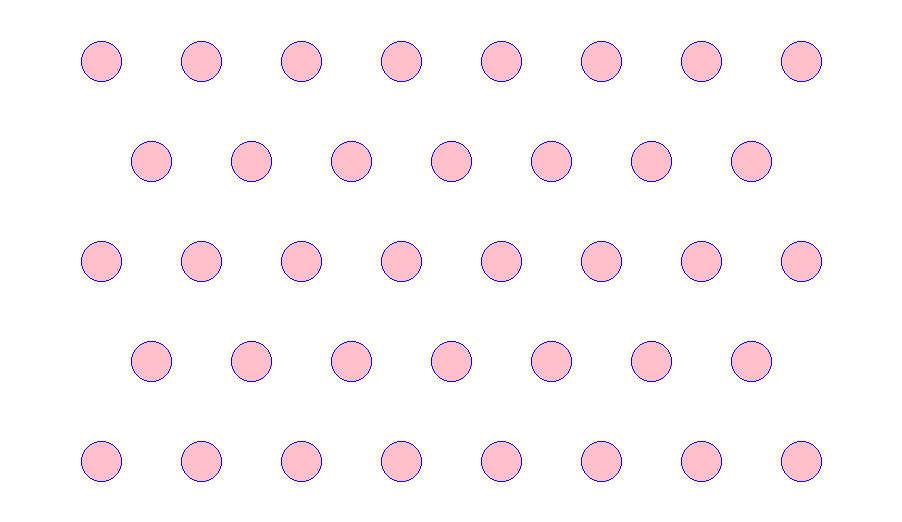

In [17]:
from PIL import Image, ImageDraw, ImageOps
import numpy as np

OVAL_RADIUS=20
LINE_THICKNESS=10
KNOT_SPACING=3*OVAL_RADIUS
HORIZ_MARGIN=80
VERT_MARGIN=40

num_rows=5
num_threads=16
num_cols=int(np.floor(float(num_threads)/2))

image = Image.new('RGBA',
                   (HORIZ_MARGIN*2+(num_cols*OVAL_RADIUS*2)+((num_cols-1)*KNOT_SPACING), VERT_MARGIN*2+(num_rows*OVAL_RADIUS*2)+((num_rows-1)*KNOT_SPACING))
                   ) # width x height
draw = ImageDraw.Draw(image)
for row in range(num_rows):
    for col in range(num_cols):
        if(row%2==0): # if row is even
            oval_x_start=HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_SPACING)
        else: # if row is odd
            oval_x_start=(OVAL_RADIUS)+(KNOT_SPACING/2)+HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_SPACING)
            if(num_threads%2==0 and col==num_cols-1):
                continue

        oval_y_start=VERT_MARGIN+(2*row*OVAL_RADIUS)+(row*KNOT_SPACING)
        draw.ellipse((oval_x_start, oval_y_start, oval_x_start+OVAL_RADIUS*2, oval_y_start+OVAL_RADIUS*2), fill = 'pink', outline ='blue')
#draw.line([(0,0),(100,100)], fill='red', width=LINE_THICKNESS)
image=ImageOps.expand(image, border=1, fill='white')
display(image)
